In [31]:
import networkx as nx
import Graph_Sampling as gs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp

In [2]:
network = nx.barabasi_albert_graph(n=5000, m=2)

In [3]:
size = len(network.nodes())
size_15 = size * 0.15

In [4]:
ff = gs.ForestFire()
g_ff = ff.forestfire(network, size_15)


In [5]:
sb = gs.Snowball()
g_sb = sb.snowball(network, size_15, 3)

In [6]:
srw_rwf_isrw = gs.SRW_RWF_ISRW()
g_rwf = srw_rwf_isrw.random_walk_sampling_with_fly_back(network, size_15, 0.3)

In [7]:
g_ff_degree = dict(g_ff.degree)
g_sb_degree = dict(g_sb.degree)
g_rwf_degree = dict(g_rwf.degree)
g_degree = dict(network.degree)

In [8]:
datasets = [g_degree, g_ff_degree, g_sb_degree, g_rwf_degree]
labels = ['100%', 'FF', 'SB', 'RWF']
df = pd.concat(
    [pd.DataFrame({'X': list(data.keys()), 'Y': list(data.values()), 'Dataset': label}) 
     for data, label in zip(datasets, labels)]
)

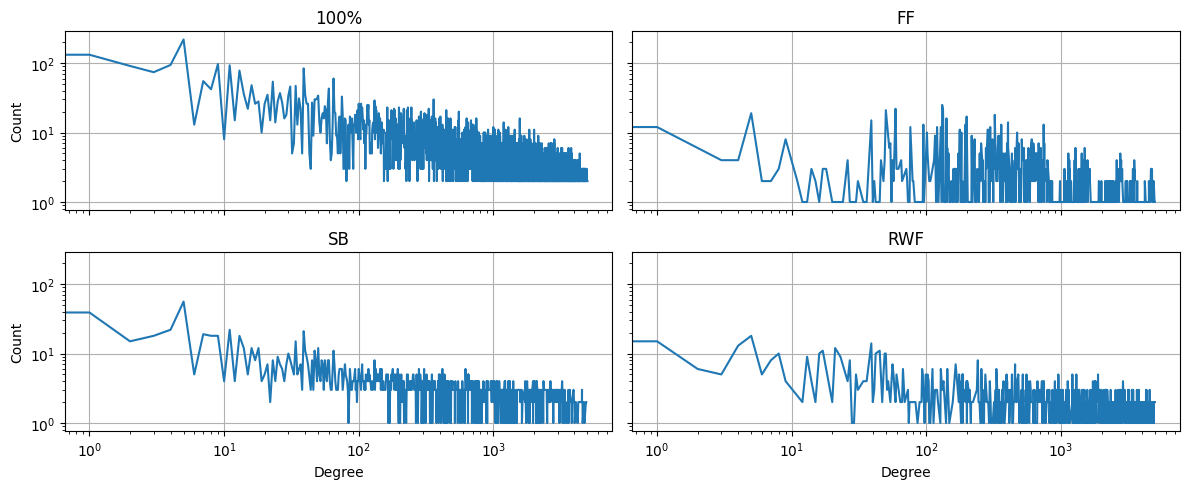

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5), sharex=True, sharey=True)
axes = axes.flatten()

for ax, label in zip(axes, labels):
    sns.lineplot(data=df[df['Dataset'] == label], x='X', y='Y', ax=ax)
    ax.set_title(label)
    ax.set_ylabel("Count")
    ax.set_xlabel("Degree")
    ax.set(xscale="log", yscale="log")
    ax.grid(True)

plt.tight_layout()

plt.show()


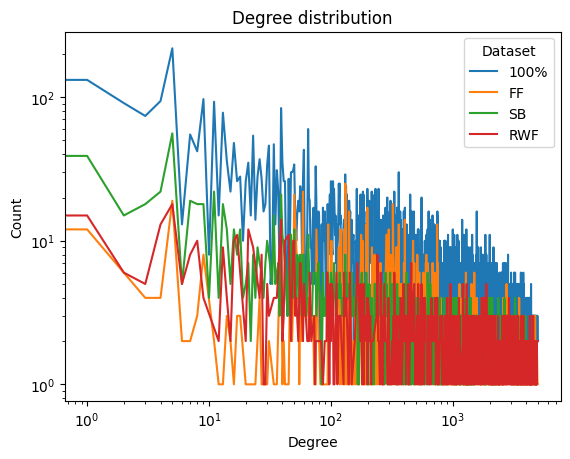

In [10]:
sns.lineplot(data=df, x='X', y='Y', hue='Dataset')
plt.title("Degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")
plt.show()

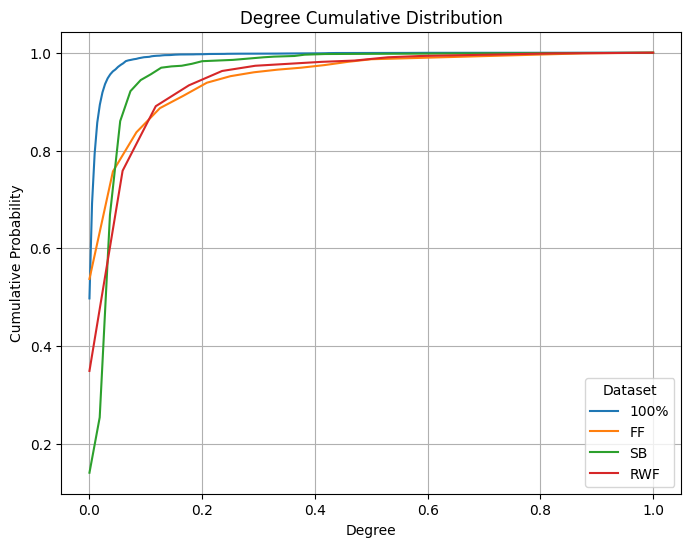

In [11]:
results = []
scaler = MinMaxScaler()

for dataset, label in zip(datasets, labels):
    degrees = [degree for _, degree in dataset.items()]

    degree_count = pd.Series(degrees).value_counts().sort_index()
    degree_cumsum = degree_count.cumsum()
    degree_cdf = degree_cumsum / degree_cumsum.iloc[-1]
    
    normalized_degrees = scaler.fit_transform(degree_count.index.values.reshape(-1, 1)).flatten()

    results.append(pd.DataFrame({
        "X": normalized_degrees,
        "Y": degree_cdf.values,
        "Dataset": label
    }))

results = pd.concat(results)

plt.figure(figsize=(8, 6))
sns.lineplot(data=results, x="X", y="Y", hue="Dataset")
plt.title("Degree Cumulative Distribution")
plt.xlabel("Degree")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.show()


In [15]:
results.head()

,X,Y,Dataset
0,0.000000,0.4976,100%
1,0.004608,0.6920,100%
2,0.009217,0.7938,100%
3,0.013825,0.8570,100%
4,0.018433,0.8938,100%


In [34]:
ks = []

cdf_100 = results[results.Dataset == "100%"].Y.values

for label in labels[1:]:
    cdf = results[results.Dataset == label].Y.values
    res = ks_2samp(cdf_100, cdf)

    ks.append(pd.DataFrame({
        'Dataset': label,
        'KS Statistic': res.statistic,
        'P-Value': res.pvalue
    }, index=[0]))

ks = pd.concat(ks).reset_index(drop=True)

In [29]:
ks

,Dataset,KS Statistic,P-Value
0,FF,0.346484,0.035157
1,SB,0.348113,0.043872
2,RWF,0.279481,0.237115
